## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [2]:
import pandas as pd

In [3]:
import io

# Загрузка данных
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(io.StringIO(uploaded['data.csv'].decode('utf-8'))) # преобразование байтового объекта в строковый объект

print(data.head())

Saving data.csv to data (1).csv
   L1_S24_F1844  L1_S24_F1846  Response
0        -0.123         0.111         0
1        -0.269         0.175         0
2        -0.058         0.141         0
3         0.136        -0.145         0
4         0.045        -0.094         0


## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


Номер ядра выберем по формуле: (2 mod 6) + 1, т.е. это будет ядро с номером 3 – линейное (треугольник).

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

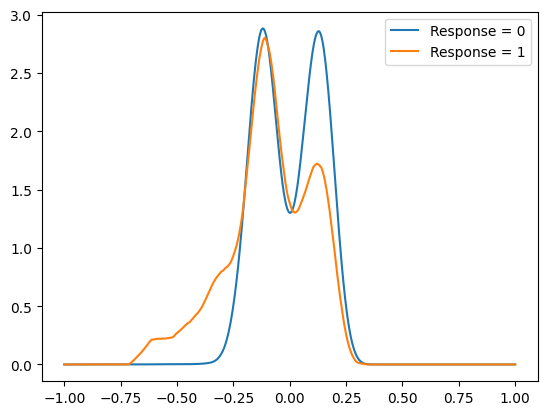

In [13]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

# создаем два флага: i0 для значений Response = 0 и i1 для значений Response = 1
i0 = data['Response'] == 0
i1 = data['Response'] == 1

# применяем метод kernel density estimation (KDE) для оценки плотности вероятности значений
# L1_S24_F1846 по каждому классу Response. Создаем объекты kde0 и kde1 с заданными параметрами kernel, bandwidth.
# reshape() нужен для преобразования вектора значений в столбец.
kde0 = KernelDensity(kernel='linear', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
kde1 = KernelDensity(kernel='linear', bandwidth=0.1).fit(data.loc[i1, 'L1_S24_F1846'].values.reshape(-1, 1))

# задаем интервал значений для оси x, затем оцениваем плотность вероятности в каждой точке интервала
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)

log_dens0 = kde0.score_samples(X_plot)
dens0 = np.exp(log_dens0)

log_dens1 = kde1.score_samples(X_plot)
dens1 = np.exp(log_dens1)

# строим график оцененных плотностей вероятности для каждого класса Response
plt.plot(X_plot, dens0, label='Response = 0')
plt.plot(X_plot, dens1, label='Response = 1')
plt.legend()
plt.show()

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [9]:
# На основании построенных графиков плотности распределения можно сделать вывод, что выборка не является хорошо 
# разделимой по признаку L1_S24_F1846 для Response=0 и Response=1, так как плотности для разных классов в значительной мере перекрываются.

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [14]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [19]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Задаем начальное значение целевой переменной r = 0
r = 0
# Создаем экземпляр класса KernelDensity с ядром Гаусса и шириной окна 0.05. Обучаем его на тренировочных данных.
kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
# Вычисляем логарифмы плотности вероятности для тестовой выборки
logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
# Заменяем бесконечные значения в массиве логарифмов плотности на -100
logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
# Вычисляем сумму логарифмов плотности вероятности
logLikehood0 = logProbability0.sum()
# Выводим на экран значение логарифма правдоподобия для целевой переменной r = 0
print(logLikehood0)

# Задаем значение целевой переменной r = 1
r = 1
# Создаем экземпляр класса KernelDensity с ядром Гаусса и шириной окна 0.05. Обучаем его на тренировочных данных.
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.05)
kde1.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
# Вычисляем логарифмы плотности вероятности для тестовой выборки
logProbability1 = kde1.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
# Заменяем бесконечные значения в массиве логарифмов плотности на -100
logProbability1[np.isinf(logProbability1)] = -100 # заменяем -бесконечность
# Вычисляем сумму логарифмов плотности вероятности
logLikehood1 = logProbability1.sum()
# Выводим на экран значение логарифма правдоподобия для целевой переменной r = 1
print(logLikehood1)

20545.783267529725
103.98787944779144


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [20]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [22]:
import numpy as np

# считаем p(x|0) и p(x|1) для тестовой выборки
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

# находим p(0|x) и p(1|x) по формуле Байеса
p0givenX = predictionProbXafter0 / (predictionProbXafter0 + predictionProbXafter1)
p1givenX = predictionProbXafter1 / (predictionProbXafter0 + predictionProbXafter1)

# определение количества бракованных деталей среди последних 100 объектов в отсортированном ряду
ind = np.argsort(p1givenX)
print(p1givenX[ind[-10:]])
print(sum(dataTest.loc[ind[-100:],'Response']))

[0.99137411 0.99182216 0.99182216 0.9919103  0.99195385 0.99195385
 0.99216571 0.99216571 0.99244186 0.99245004]
29
